## Real GDP growth by state

Updated January 11, 2019

See: 

* [BEA GDP by State](https://www.bea.gov/data/gdp/gdp-state)

* [BEA API example](https://github.com/bdecon/econ_data/blob/master/APIs/BEA.ipynb)

* [Basemap - Working with shapefiles](https://basemaptutorial.readthedocs.io/en/latest/shapefile.html)

* [Related shapefiles here](https://github.com/bdecon/US-chartbook/tree/master/notebooks/shapefiles)


In [1]:
# Settings and packages
%matplotlib inline

import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon

plt.rc('font', family='Lato')

from mpl_toolkits.basemap import Basemap

# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

In [3]:
# Collect data from API and store in database
api_results = bea_api_gdpstate(bea_key)

bea_to_db(api_results)

In [25]:
# Retrieve data
data = gdpstate_df(retrieve_table('SQGDP9')['Data'])

states = list(set([i['STATE_NAME'] for i in m.states_info]))
regions = list(set([i['SUB_REGION'] for i in m.states_info]))
region_mapping = {region: list(set([i['STATE_NAME'] for i in m.states_info 
                                    if i['SUB_REGION'] == region])) 
                  for region in regions}

for region, state_list in region_mapping.items():
    data[region] = data[state_list].sum(axis=1)

data = data.drop([c for c in data.columns 
                  if c not in states 
                  and c not in regions
                  and c != 'United States'], axis=1)    
    
d = {}
oneyr = data.pct_change(4).iloc[-1] * 100
tenyr = data.pct_change(41).iloc[-1] * 100
threeyr = data.pct_change(13).iloc[-1] * 100
last5 = ((1 + data.pct_change().iloc[-5:]) ** 4 - 1) * 100
d[0] = data.iloc[-5:]
d[1] = data.iloc[-5:]
d[2] = growth_rate(data).iloc[-1]
d[3] = oneyr

# Max and min values for label 
lmax = 8
lmin = -8

cmap = plt.cm.Spectral
norm = Normalize(vmin=lmin, vmax=lmax)

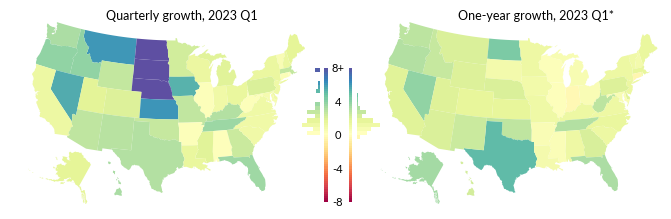

In [49]:
# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.2, 2.5))
fig.tight_layout()

for group in [0, 1]:
    plt.sca(axes[group])
    axes[group].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        fc = cmap(norm(d[group + 2][info['STATE_NAME']]))
        # Alaska and Hawaii moved
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[group].add_patch(Polygon(shape, fc=fc))
    
    date = f'{d[group].index[-1].year} Q{d[group].index[-1].quarter}'
    date = date + '*' if group == 1 else date
    txt = 'Quarterly growth' if group == 0 else 'One-year growth'
    plt.text(0.32, 0.99, f'{txt}, {date}', fontsize=9, 
             transform=axes[group].transAxes)
    
# Draw custom legend    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [lmin, int(lmin/2), 0, int(lmax/2), lmax]:
    tick_txt = f'{tick_label}+' if tick_label == lmax else tick_label
    plt.text(0.6, norm(tick_label), tick_txt, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

for group, pt, pt2 in [(0, 0.71, 0.8), (1, 0.44, 0.39)]:
    for i in np.linspace(lmin,lmax,65):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/64, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    vals = d[group+2][states]
    vals.loc[vals > lmax] = lmax # Replace out of boundary values with lmax
    bins = pd.cut(vals, np.linspace(lmin,lmax,33)).apply(lambda x: x.left)
    res = vals.groupby(bins).count()
    for i, v in res.items():
        adj = (v / 50) if group == 0 else 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/32, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/gdp_map.pgf', bbox_inches='tight')

In [14]:
# Generate text
date = dtxt(d[0].index[-1])['qtr1']
write_txt(text_dir / 'gdp_state_date.txt', date)    

numbers = {0: 'no', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 
           6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}

cuts = [(10, 50), (5, 10), (0, 5), (-50, 0)]

td = {}
sd = oneyr.loc[states].round(1) # Keep only states + DC (drop regions)
for minval, maxval in cuts:
    grp = sd[(sd >= minval) & (sd < maxval)]    
    val = len(grp) if 'District of Columbia' not in grp else len(grp) - 1
    if val < 10:
        txtval = numbers[val]
    else:
        txtval = str(val)
    if val == 1:
        td[maxval] = txtval + f' state ({grp.index[0]})'
    else:
        td[maxval] = txtval + ' states'
    # Add DC manually
    if 'District of Columbia' in grp:
        if val > 1:
            td[maxval] = td[maxval] + ' and the District of Columbia'
        if val == 1:
            td[maxval] = 'only the District of Columbia'  
            
# Check for cases without high growth states    
t1 = (f'{td[50]} had real GDP growth of more than ten percent, '+
      f'{td[10]} had real GDP growth between five and ten percent, ')
if (td[50] == 'no states') & (td[10] == 'no states'):
    t1 = 'no states had real GDP growth of more than five percent, '
       
text = (f'Over the year ending {date}, {t1}{td[5]} had growth between '+
        f'zero and five percent, and {td[0]} had '+
        'negative GDP growth. ')
write_txt(text_dir / 'gdp_state.txt', text)
print(text)

Over the year ending 2023 Q1, no states had real GDP growth of more than ten percent, one state (Texas) had real GDP growth between five and ten percent, 47 states and the District of Columbia had growth between zero and five percent, and two states had negative GDP growth. 


In [8]:
# Create latex table
f = data_dir / 'gdp_state_table.tex'
os.remove(f)

newpage = '\end{tabular} } \\\\ \\newpage'

header = """\hspace{-2mm} \\noindent \\rowcolors{1}{}{black!5} 
            \setlength{\\tabcolsep}{2.0pt} \color{black!90}
            {\\renewcommand{\\arraystretch}{1.44}
             \\begin{tabular}{p{29mm} R{8.5mm} R{8.5mm} R{8.5mm} R{8.5mm} 
             R{8.5mm} p{0mm} R{11mm} R{11mm} R{12mm} }"""

contdrow = "\multicolumn{3}{l}{continued on next page . . .} & &  & & & & & \\\\"
contdrow2 = "\multicolumn{3}{l}{continued from previous page . . .}  & &  & & & & & \\\\"

tbl_dates = {}
for i in range(1, 6):
    dt = last5['Alabama'].index[-i]
    tbl_dates[i] = f'{dt.year} Q{dt.quarter}'

i = 0 
        
daterow = (f' & {tbl_dates[1]} & {tbl_dates[2]} & {tbl_dates[3]} & {tbl_dates[4]}'
           f' & {tbl_dates[5]} & & 1-year* & 3-year & 10-year \\\\')
with open(f, 'a') as table:
    table.write(daterow + '\n')
    area = 'United States'
    rate = f"{oneyr[area]:.1f} & {threeyr[area]:.1f} & {tenyr[area]:.1f} \\\\"
    last = ' & '.join(last5[area].iloc[-1::-1].round(1).astype(str).values)
    table.write('\\textbf{' + area + '}  & ' + last + ' &  & ' + rate + '\n')
    i = i + 1
    
    reg_sorted = list(tenyr.loc[regions].sort_values(ascending=False).index)

    for region in reg_sorted:
        rate = f"{oneyr[region]:.1f} & {threeyr[region]:.1f} & {tenyr[region]:.1f} \\\\"
        last = ' & '.join(last5[region].iloc[-1::-1].round(1).astype(str).values)
        table.write('\hspace{1mm} \\textbf{' + region + '}  & ' + last + ' &  & ' + rate + '\n')
        i = i + 1
        region_mapping[region]
        for state in list(tenyr[region_mapping[region]].sort_values(ascending=False).index):
            rate = f"{oneyr[state]:.1f} & {threeyr[state]:.1f} & {tenyr[state]:.1f} \\\\"
            last = ' & '.join(last5[state].iloc[-1::-1].round(1).astype(str).values)
            table.write('\hspace{3mm}  ' + state + '  & ' + last + ' &  & ' + rate + '\n')
            i = i + 1
            if i == 21:
                table.write(contdrow + '\n')
                table.write(newpage + '\n')
                table.write('' + '\n')
                table.write(header + '\n')
                table.write(daterow + '\n')
                table.write(contdrow2 + '\n')